In [1]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Filter annoying torchvision warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.transforms.functional")

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"  # Ensure this file is in your folder
BATCH_SIZE = 16
LEARNING_RATE = 5e-5 # Low LR for fine-tuning
EPOCHS = 15

print(f"🧬 Initializing Hybrid Framework on {DEVICE}...")


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧬 Initializing Hybrid Framework on cuda...


In [2]:

# ==========================================
# 2. HYBRID DATASET (Image + Physics)
# ==========================================
class HybridDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols
        
        # Audio Transforms
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        
        # Image Transforms (Antialias fix included)
        self.resize = T.Resize((224, 224), antialias=True) 
        self.norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # A. LOAD AUDIO (ResNet Input)
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        
        # Generate Spectrogram Image
        img = self.resize(self.db(self.mel(wav))).repeat(3, 1, 1) # 1ch -> 3ch
        img = (img - img.min()) / (img.max() - img.min() + 1e-6) # MinMax Scale
        img = self.norm(img) # ImageNet Norm
        
        # B. LOAD PHYSICS (Dual-Stream Input)
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        
        return img, torch.tensor(norm_sfm, dtype=torch.float32), torch.tensor(row['label_encoded'], dtype=torch.long)

# ==========================================
# 3. HYBRID MODEL ARCHITECTURE
# ==========================================
class HybridResNetDual(nn.Module):
    def __init__(self, num_classes, physics_dim=10):
        super().__init__()
        
        # Branch 1: ResNet-34 (Vision)
        print("    Loading Pre-trained ResNet-34...")
        resnet = models.resnet34(pretrained=True)
        
        # Remove the final classification layer to get features
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1]) 
        self.resnet_dim = 512
        
        # Branch 2: Physics MLP (Math)
        self.physics_mlp = nn.Sequential(
            nn.Linear(physics_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        self.physics_out_dim = 128
        
        # Fusion Layer (Concatenate Vision + Physics)
        fusion_dim = self.resnet_dim + self.physics_out_dim # 512 + 128 = 640
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, physics):
        # 1. Vision Path
        vis_feat = self.resnet_features(images) # [Batch, 512, 1, 1]
        vis_feat = vis_feat.view(vis_feat.size(0), -1) # Flatten -> [Batch, 512]
        
        # 2. Physics Path
        phys_feat = self.physics_mlp(physics) # [Batch, 128]
        
        # 3. Fusion
        combined = torch.cat((vis_feat, phys_feat), dim=1) # [Batch, 640]
        
        # 4. Classification
        return self.classifier(combined)


In [3]:

# ==========================================
# 4. DATA PREPARATION
# ==========================================
if not os.path.exists(SFM_CSV):
    print(f"❌ ERROR: '{SFM_CSV}' not found. Please upload dataset.")
else:
    full_df = pd.read_csv(SFM_CSV)
    le = LabelEncoder()
    full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
    NUM_CLASSES = len(le.classes_)
    print(f"📋 Classes Detected: {le.classes_}")

    sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
    scaler = StandardScaler().fit(full_df[full_df['split'] == 'train'][sfm_cols].values)

    # Initialize Datasets
    train_ds = HybridDataset(full_df[full_df['split'] == 'train'], scaler, sfm_cols)
    val_ds = HybridDataset(full_df[full_df['split'] == 'val'], scaler, sfm_cols)
    test_ds = HybridDataset(full_df[full_df['split'] == 'test'], scaler, sfm_cols)

    # Initialize Loaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


📋 Classes Detected: ['Cysts_Structural' 'Dysarthia' 'Laryngitis' 'Vox senilis' 'parkinson'
 'spasmodische_dysphonie']


In [4]:

# ==========================================
# 5. TRAINING LOOP
# ==========================================
model = HybridResNetDual(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n🔥 Starting Hybrid Training...")
best_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for imgs, phys, labels in train_loader:
        imgs, phys, labels = imgs.to(DEVICE), phys.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(imgs, phys)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for imgs, phys, labels in val_loader:
            imgs, phys = imgs.to(DEVICE), phys.to(DEVICE)
            logits = model(imgs, phys)
            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_targets.extend(labels.numpy())
            
    val_acc = accuracy_score(val_targets, val_preds)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_hybrid_resnet_dual.pth")
        print(f"    💾 Saved Best Model ({val_acc:.4f})")


    Loading Pre-trained ResNet-34...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔥 Starting Hybrid Training...
Epoch 1/15 | Loss: 0.8051 | Val Acc: 0.8822
    💾 Saved Best Model (0.8822)
Epoch 2/15 | Loss: 0.3922 | Val Acc: 0.9159
    💾 Saved Best Model (0.9159)
Epoch 3/15 | Loss: 0.2330 | Val Acc: 0.9231
    💾 Saved Best Model (0.9231)
Epoch 4/15 | Loss: 0.1383 | Val Acc: 0.8990
Epoch 5/15 | Loss: 0.0922 | Val Acc: 0.9231
Epoch 6/15 | Loss: 0.0793 | Val Acc: 0.9279
    💾 Saved Best Model (0.9279)
Epoch 7/15 | Loss: 0.0615 | Val Acc: 0.9183
Epoch 8/15 | Loss: 0.0468 | Val Acc: 0.9351
    💾 Saved Best Model (0.9351)
Epoch 9/15 | Loss: 0.0444 | Val Acc: 0.9207
Epoch 10/15 | Loss: 0.0379 | Val Acc: 0.9183
Epoch 11/15 | Loss: 0.0573 | Val Acc: 0.9159
Epoch 12/15 | Loss: 0.0330 | Val Acc: 0.9327
Epoch 13/15 | Loss: 0.0247 | Val Acc: 0.9399
    💾 Saved Best Model (0.9399)
Epoch 14/15 | Loss: 0.0169 | Val Acc: 0.9087
Epoch 15/15 | Loss: 0.0570 | Val Acc: 0.9183



🚀 Evaluating Best Model on Test Set...

🏆 FINAL HYBRID ACCURACY: 93.32%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       0.86      0.86      0.86        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.71      0.88      0.79        42
           Vox senilis       0.98      0.87      0.92        93
             parkinson       0.98      0.99      0.99       200
spasmodische_dysphonie       0.78      0.70      0.74        20

              accuracy                           0.93       419
             macro avg       0.88      0.88      0.88       419
          weighted avg       0.94      0.93      0.93       419



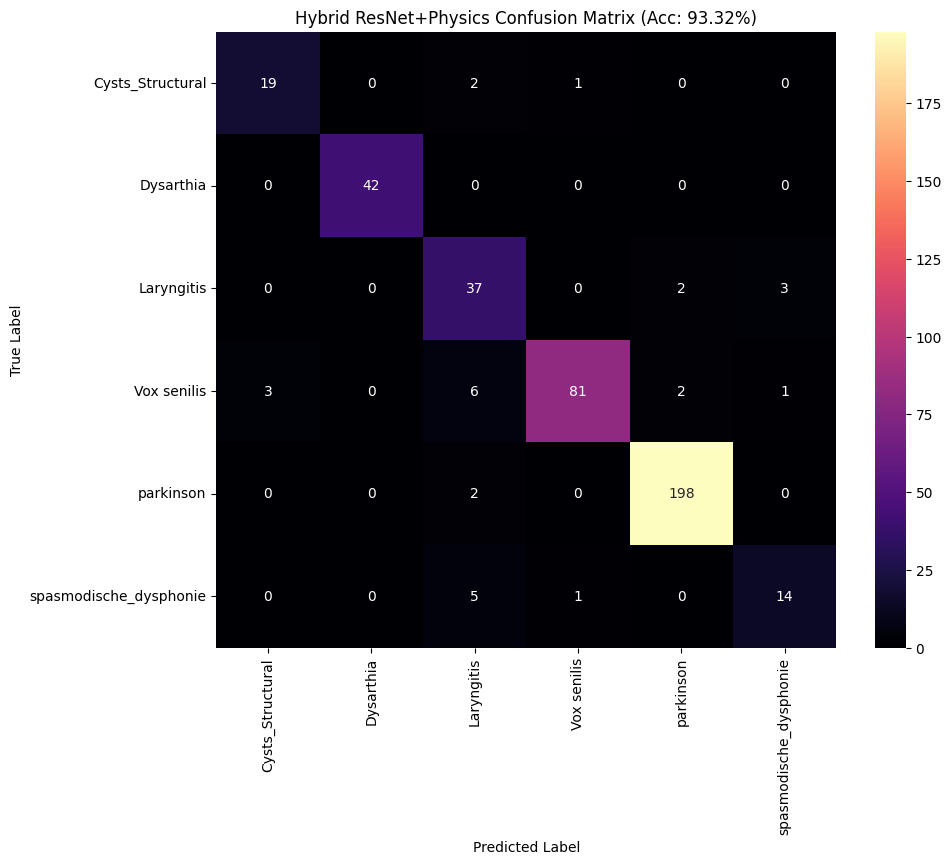


🔍 Analyzing Physics Feature Importance...


C:\Users\sreeh\AppData\Local\Temp\ipykernel_7572\35793819.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=sfm_cols, palette="viridis")


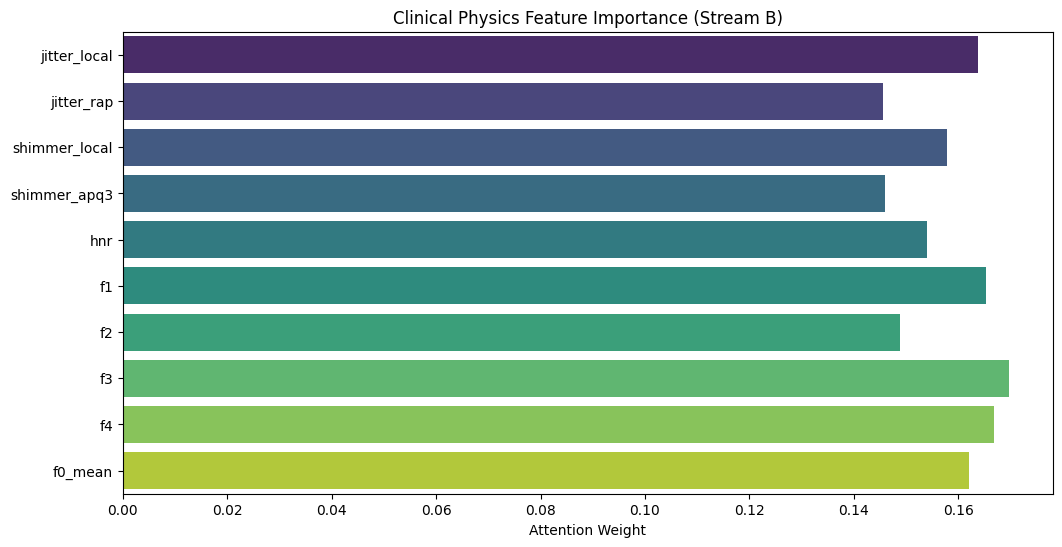

In [5]:

# ==========================================
# 6. FINAL EVALUATION
# ==========================================
print("\n🚀 Evaluating Best Model on Test Set...")
model.load_state_dict(torch.load("best_hybrid_resnet_dual.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, phys, labels in test_loader:
        imgs, phys = imgs.to(DEVICE), phys.to(DEVICE)
        logits = model(imgs, phys)
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Metrics
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 FINAL HYBRID ACCURACY: {test_acc*100:.2f}%")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion Matrix Plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Hybrid ResNet+Physics Confusion Matrix (Acc: {test_acc*100:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ==========================================
# 7. FEATURE IMPORTANCE (Physics Stream)
# ==========================================
# We visualize which physics features the model found most useful
print("\n🔍 Analyzing Physics Feature Importance...")
weights = model.physics_mlp[0].weight.detach().cpu().numpy()
importance = np.mean(np.abs(weights), axis=0)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance, y=sfm_cols, palette="viridis")
plt.title("Clinical Physics Feature Importance (Stream B)")
plt.xlabel("Attention Weight")
plt.show()